In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import xgcm
from cmocean import cm
from xgcm.autogenerate import generate_grid_ds
from functools import partial
from scipy.signal import butter, filtfilt

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

In [2]:
if True:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster()
    cluster = PBSCluster() # necessary?
    w = cluster.scale(jobs=5)
    # 3 needed for lagrangian lon/lat binning
    # 15 for eulerian binning
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
    client

In [4]:
client

Client Scheduler: tcp://10.148.0.6:54264 Dashboard: http://10.148.0.6:8787/status,Cluster Workers: 7 Cores: 7 Memory: 111.79 GiB


_________
# 1. Read dataset


In [5]:
raw_dir_work = '/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/'

grid = xr.open_dataset(raw_dir_work+'Grid.nc', decode_coords=True)
ds_U = xr.open_zarr(raw_dir_work+'U_total_rechunk.zarr')
ds_V = xr.open_zarr(raw_dir_work+'V_total_rechunk.zarr')

ds = xr.merge([ds_U,ds_V,grid])
ds = generate_grid_ds(ds, {'Z':'depth'})
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:     (depth: 52, depth_left: 52, lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates: (12/22)
  * lat         (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon_g       (lon_g) float64 -18.04 -18.02 -18.0 ... -14.42 -14.4 -14.38
  * depth       (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * time        (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * lat_g       (lat_g) float64 47.4 47.41 47.42 47.44 ... 49.96 49.97 49.98
  * lon         (lon) float64 -18.03 -18.01 -17.99 ... -14.41 -14.39 -14.36
    ...          ...
    dyG         (lat, lon_g) float32 ...
    rA          (lat, lon) float32 ...
    rAz         (lat_g, lon_g) float32 ...
    rAw         (lat, lon_g) float32 ...
    rAs         (lat_g, lon) float32 ...
  * depth_left  (depth_left) float64 -0.035 1.035 2.18 ... 878.0 922.9 968.9
Data variables:
    U           (time, depth, lat, lon_g) float32 dask.array<chunksize=(94

In [6]:
gridx = xgcm.Grid(ds, coords={'X':{'center':'lon', 'left':'lon_g'},
                              'Y':{'center':'lat', 'left':'lat_g'},
                              'Z':{'center':'depth', 'left':'depth_left'}}, periodic=['X', 'Y'])
print(gridx)

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   lon --> left
  * left     lon_g --> center
Y Axis (periodic, boundary=None):
  * center   lat --> left
  * left     lat_g --> center
Z Axis (not periodic, boundary=None):
  * center   depth --> left
  * left     depth_left --> center


# 2. Filter

In [7]:
out_dir_zarr = '/home1/scratch/xyu/KE/data_rechunk_filter/'

def butter_filter(x, b, a):
    return xr.apply_ufunc(partial(filtfilt, b, a),
                          x.chunk(),
                          dask='parallelized',
                          output_dtypes=[x.dtype],
                          kwargs={'axis': 0})

## bandpass (f band)

In [6]:
15.9*0.9

14.31

In [7]:
15.9*1.1

17.490000000000002

In [8]:
highcut = 1/14.3/3600
lowcut = 1/17.5/3600

fs = 1/3600
nyq = 0.5*fs
low = lowcut/nyq
high = highcut/nyq

b, a = butter(4, [low, high], 'bandpass')

In [9]:
# rechunk data first
chunks = {'time': 9415, 'lat': 1, 'lon_g': 1, 'depth':52}
U = ds.U.chunk(chunks)
del U.depth.encoding['chunks']

# filter
U_filter = butter_filter(ds.U, b, a)
U_NI_filter = np.real(U_filter).rename('U_NI_filter')
U_NI_filter = U_NI_filter.to_dataset()

# rechunk data again
chunks = {'time': 9415, 'lat': 1, 'lon_g': 177, 'depth':1}
U_NI_filter = U_NI_filter.chunk(chunks)
U_NI_filter = U_NI_filter.drop(['dxC','dyG','rAw'])

U_bandpass_filter = gridx.interp(U_NI_filter.U_NI_filter,'X')
U_bandpass_filter = np.real(U_bandpass_filter).rename('U_bandpass_filter')
print(U_bandpass_filter)

<xarray.DataArray 'U_bandpass_filter' (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<real, shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 1, 176), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36


In [10]:
# rechunk data first
chunks = {'time': 9415, 'lat_g': 1, 'lon': 1, 'depth':52}
V = ds.V.chunk(chunks)
del V.depth.encoding['chunks']

# filter
V_filter = butter_filter(ds.V, b, a)
V_NI_filter = np.real(V_filter).rename('V_NI_filter')
V_NI_filter = V_NI_filter.to_dataset()

# rechunk data again
chunks = {'time': 9415, 'lat_g': 1, 'lon': 177, 'depth':1}
V_NI_filter = V_NI_filter.chunk(chunks)
V_NI_filter = V_NI_filter.drop(['dxG','dyC','rAs'])

V_bandpass_filter = gridx.interp(V_NI_filter.V_NI_filter,'Y')
V_bandpass_filter = np.real(V_bandpass_filter).rename('V_bandpass_filter')
print(V_bandpass_filter) 

<xarray.DataArray 'V_bandpass_filter' (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<real, shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 1, 177), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36


In [11]:
KE_NI_filter = 1025*(U_bandpass_filter**2 + V_bandpass_filter**2)/2 # KE
KE_NI_filter = np.real(KE_NI_filter).rename('KE_NI_filter')
print(KE_NI_filter)

<xarray.DataArray 'KE_NI_filter' (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<real, shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 1, 176), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36


In [12]:
out_dir_store = '/home1/scratch/xyu/KE/parameter/'
depth_all = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51]

In [14]:
# ~7 mins
VV = ['KE_NI_filter']

for depth in depth_all:
    
    for vv in VV:
        
        KE_NI_single = KE_NI_filter.isel(depth=depth)
        chunks = {'lat': 1, 'lon': 177, 'time':9415}            
        KE_NI_single = KE_NI_single.chunk(chunks)
        KE_NI_single = np.real(KE_NI_single).rename('KE_NI_single')     
        KE_NI_single = KE_NI_single.to_dataset()
        file_out = out_dir_store+'/%s_d%02d.zarr'%(vv,depth)
        KE_NI_single.to_zarr(file_out, mode='w')                    
        print('depth=%d - allready processed'%(depth))

depth=0 - allready processed
depth=1 - allready processed
depth=2 - allready processed
depth=3 - allready processed
depth=4 - allready processed
depth=5 - allready processed
depth=6 - allready processed
depth=7 - allready processed
depth=8 - allready processed
depth=9 - allready processed
depth=10 - allready processed
depth=11 - allready processed
depth=12 - allready processed
depth=13 - allready processed
depth=14 - allready processed
depth=15 - allready processed
depth=16 - allready processed
depth=17 - allready processed
depth=18 - allready processed
depth=19 - allready processed
depth=20 - allready processed
depth=21 - allready processed
depth=22 - allready processed
depth=23 - allready processed
depth=24 - allready processed
depth=25 - allready processed
depth=26 - allready processed
depth=27 - allready processed
depth=28 - allready processed
depth=29 - allready processed
depth=30 - allready processed
depth=31 - allready processed
depth=32 - allready processed
depth=33 - allready 

In [15]:
D = [xr.open_zarr(out_dir_store+'KE_NI_filter_d%02d.zarr'%(depth)) for depth in range(52)]
KE_NI_filter = xr.concat(D, dim='depth')
KE_NI_filter = KE_NI_filter.KE_NI_single
KE_NI_filter

,Array,Chunk
Bytes,64.89 GiB,6.36 MiB
Shape,"(52, 9415, 201, 177)","(1, 9415, 1, 177)"
Count,31408 Tasks,10452 Chunks
Type,float32,numpy.ndarray


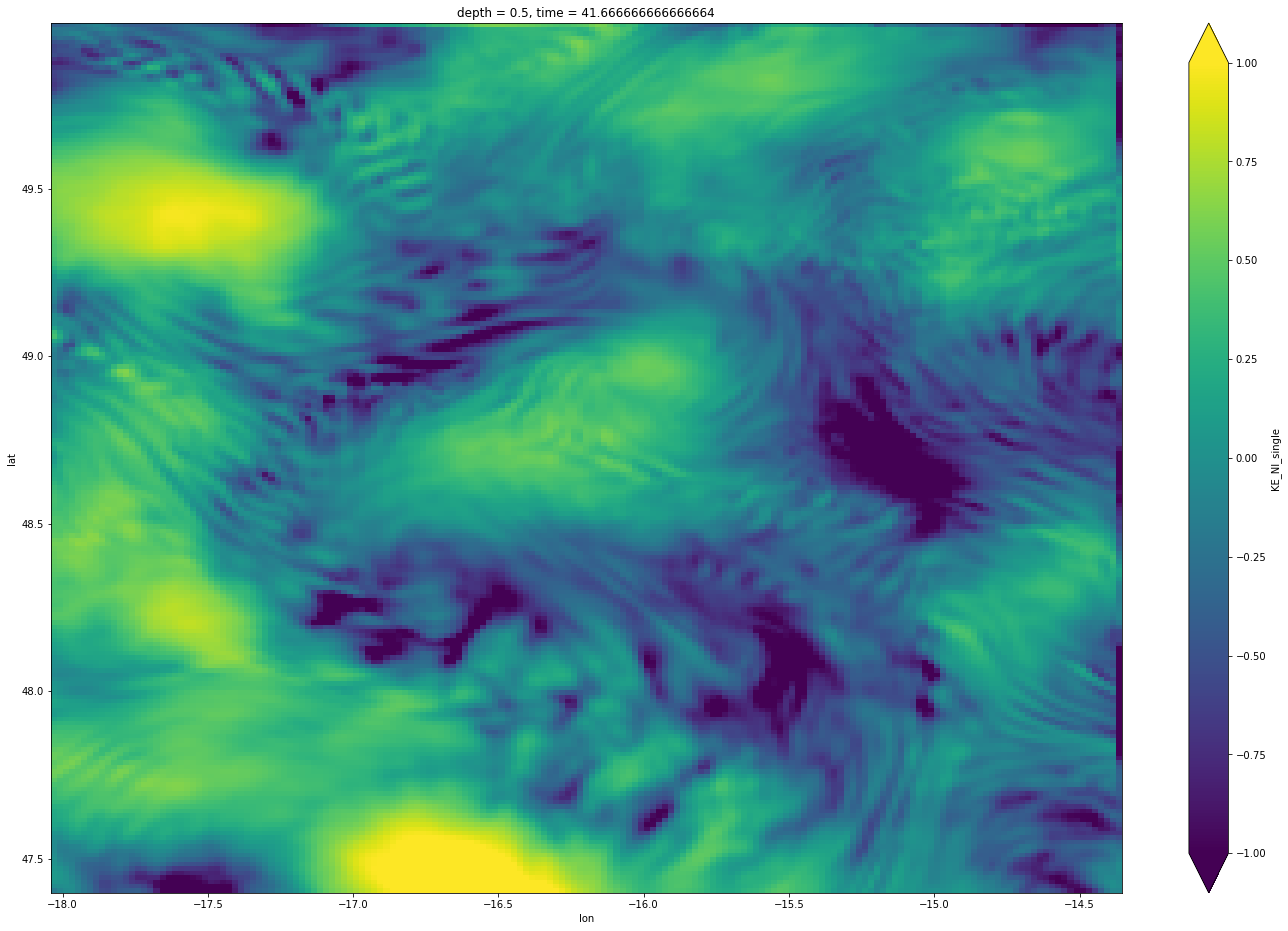

In [16]:
# Read KE
fig = plt.figure(figsize=(24,16))
np.log10(KE_NI_filter).isel(time=1000,depth=0).plot(vmin=-1,vmax=1)

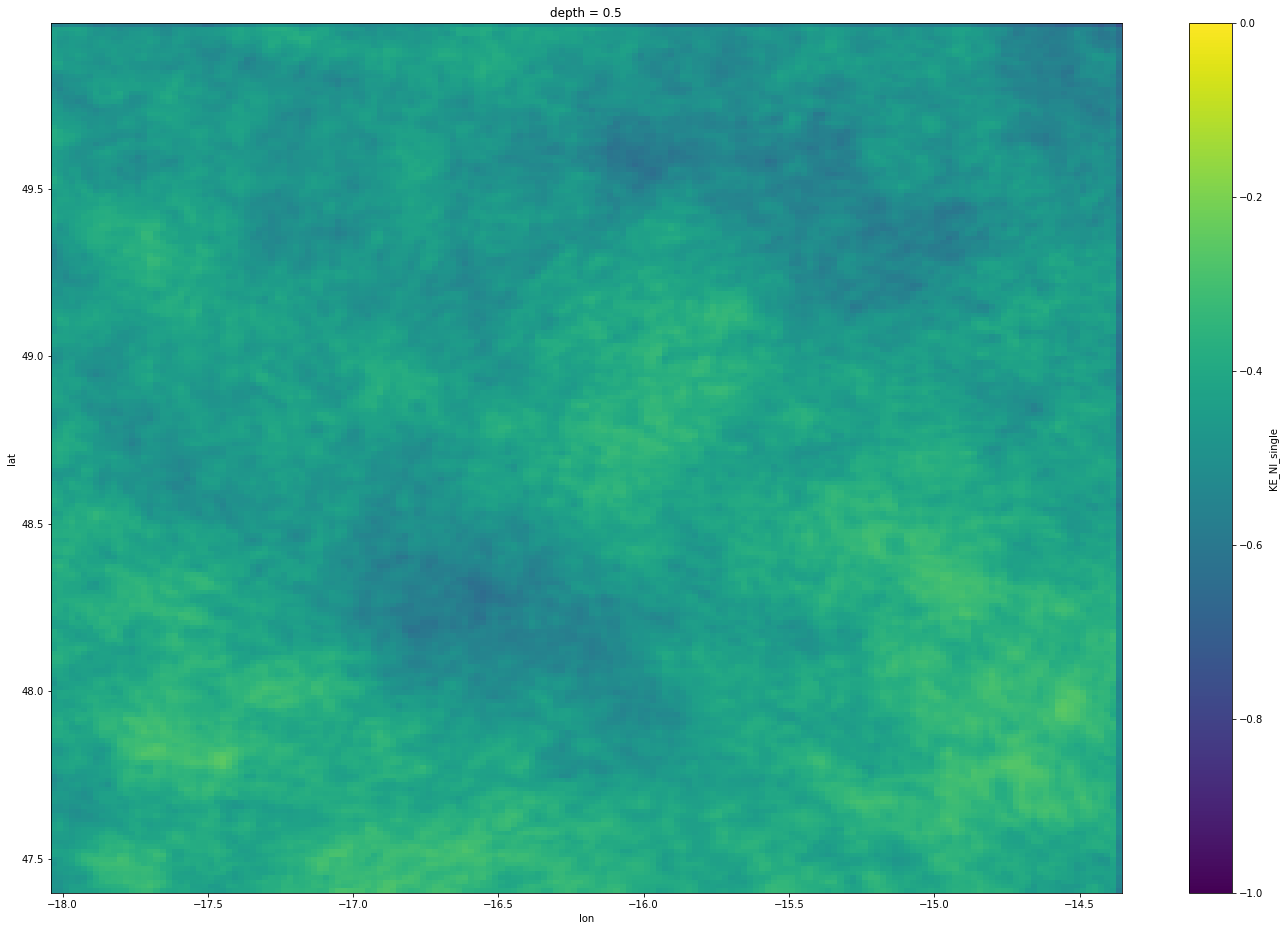

In [19]:
# Read KE
fig = plt.figure(figsize=(24,16))
np.log10(KE_NI_filter).isel(depth=0).mean('time').plot(vmin=-1,vmax=0)

In [21]:
cluster.close()